In [1]:
%matplotlib inline
# For auto-reload
%load_ext autoreload
%autoreload 2

In [2]:
# ----------------- Classics -------------------- #
import numpy as np
import pandas as pd

# ------------------- Plotting ------------------- #
import squarify
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
plt.style.use('fivethirtyeight')

# ---------------- Pandas settings --------------- #
# Removes rows and columns truncation of '...'
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

# ------------------- Python libs ---------------- #
import os
from pathlib import Path
import re
import sys
ROOT_PATH = Path().resolve().parent
sys.path.append(str(ROOT_PATH)) # Add folder root path

from tqdm import tqdm
tqdm.pandas()

import warnings
warnings.filterwarnings(action='ignore')

/home/ubuntu/.local/share/virtualenvs/kaggle-news-analysis-E_e02zD4/lib/python3.8/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


## 1. Load dataset

In [3]:
articles = pd.read_csv(ROOT_PATH.joinpath(f"data/cleaned_data/cleaned_articles.csv"), parse_dates=["date"])
articles.head()

,title,publication,date,content
0,House Republicans Fret About Winning Their Hea...,New York Times,2016-12-31,WASHINGTON — Congressional Republicans have a ...
1,Rift Between Officers and Residents as Killing...,New York Times,2017-06-19,"After the bullet shells get counted, the blood..."
2,"Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...",New York Times,2017-01-06,"When Walt Disney’s “Bambi” opened in 1942, cri..."
3,"Among Deaths in 2016, a Heavy Toll in Pop Musi...",New York Times,2017-04-10,"Death may be the great equalizer, but it isn’t..."
4,Kim Jong-un Says North Korea Is Preparing to T...,New York Times,2017-01-02,"SEOUL, South Korea — North Korea’s leader, Kim..."


In [4]:
articles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142023 entries, 0 to 142022
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   title        142007 non-null  object        
 1   publication  142023 non-null  object        
 2   date         139387 non-null  datetime64[ns]
 3   content      142023 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 4.3+ MB


In [5]:
articles.isnull().sum()

title            16
publication       0
date           2636
content           0
dtype: int64

Let's look at how many articles we have and what year range articles are in.

In [6]:
print(f"This dataset contains {len(articles)} articles written between {int(articles.date.dt.year.min())} and {int(articles.date.dt.year.max())}.")

This dataset contains 142023 articles written between 2000 and 2017.


## 2. Do statistical explorations

### Article count by publication

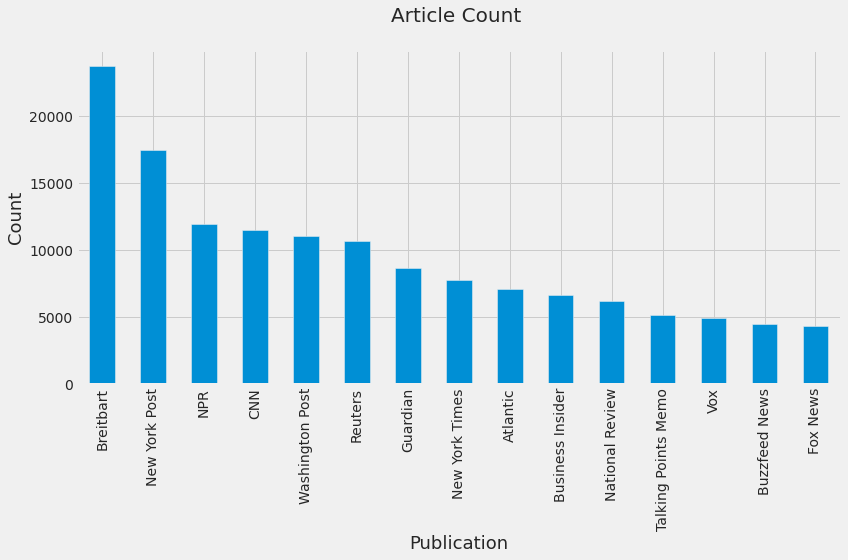

In [7]:
ax = articles['publication'].value_counts().plot(kind='bar', fontsize=14, figsize=(12,8))
ax.set_title('Article Count \n', fontsize=20)
ax.set_xlabel('Publication', fontsize=18)
ax.set_ylabel('Count', fontsize=18)
plt.tight_layout()

Looks like Breitbart, followed by New York Post and NPR make up the larget number of articles in our dataset, while Vox, BuzzFeed and Fox News make fewest.

### Length of articles

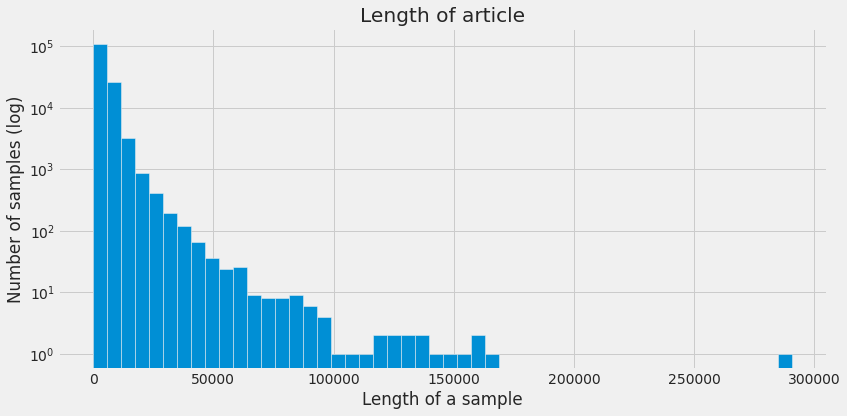

In [8]:
ax = articles["content"].apply(len).plot(kind="hist", bins=50, fontsize=14, figsize=(12, 6))
ax.set_title("Length of article")
ax.set_xlabel('Length of a sample')
ax.set_ylabel('Number of samples (log)')
ax.set_yscale("log")
plt.tight_layout()

Some of the articles are really big, while most fall below 20000 characters, let's clean the text more and remove any punctuations, lowercase it and keep alphanumeric characters.

In [9]:
print("Average length of article is: {:.2f}".format(articles["content"].apply(len).mean()))

Average length of article is: 4376.73


### Limit the analysis to 2015-2017

In [10]:
articles.date.dt.year.value_counts(normalize=True) * 100

2016.0    60.969818
2017.0    36.077253
2015.0     2.656632
2013.0     0.163573
2014.0     0.088961
2012.0     0.024393
2011.0     0.005739
2010.0     0.004305
2009.0     0.002152
2008.0     0.001435
2005.0     0.001435
2004.0     0.001435
2003.0     0.001435
2007.0     0.000717
2000.0     0.000717
Name: date, dtype: float64

We can see:

- 2016 - 2017 make up ~ 97% of the content
- 2015-2017 make up ~ 99.7% of content 

and rest are below 1% so we can limit our analysis to 2015-2017.

In [11]:
articles = articles[articles.date.dt.year >= 2015]
articles.date.dt.year.value_counts(normalize=True) * 100

2016    61.151007
2017    36.184466
2015     2.664527
Name: date, dtype: float64

In [12]:
print(articles.shape)

(138974, 4)


### Scrub unnecessary punctuations

In [13]:
import string

def scrub_words(text, lower=True, punct=True, non_ascii=True, az_chars=True, digit=True, strip_whitespaces=True, double_whitespace=True):
    """
    Removes punctuation and converts all the text to lower case, removes digits and non-ascii characters
    """
    if not type(text) == str:
        return text
    
    # lowercase text
    if lower:
        text = text.lower()
    
    # remove punctuations
    if punct:
        text = re.sub(r'['+string.punctuation + '’—”'+']', "", text)
    
    # remove non ascii
    if non_ascii:
        text =  re.sub("\W"," ",text)
    
    # removes foreign language
    if az_chars:
        text = re.sub("[^a-zA-Z]", " ", text)
        
    # removes digits
    if digit:
        text = re.sub("\d", " ", text)
    
    # replaces double whitespaces with single whitespace
    if double_whitespace:
        text =  re.sub('\s{2,}', ' ', text)
    
    # strip whitespaces from front and back
    text = text.strip()
    
    return text

# Test it out there are some foreign languages words in it
txt = " This function removes non-ascii 😀, punctuations @#$!, LOWERCASES, double  white  spaces  , $1234.00 digits, and trailing white spaces  "
scrub_words(txt)

'this function removes nonascii punctuations lowercases double white spaces digits and trailing white spaces'

### Apply text pre-processing to `title` and `content`

In [14]:
articles["cleaned_content"] = articles["content"].progress_apply(scrub_words)
articles["cleaned_title"] = articles["title"].progress_apply(scrub_words)
articles["publication"] = articles["publication"].progress_apply(scrub_words)
articles.head()

100%|██████████| 138974/138974 [00:01<00:00, 97131.72it/s] 


,title,publication,date,content,cleaned_content,cleaned_title
0,House Republicans Fret About Winning Their Hea...,new york times,2016-12-31,WASHINGTON — Congressional Republicans have a ...,washington congressional republicans have a ne...,house republicans fret about winning their hea...
1,Rift Between Officers and Residents as Killing...,new york times,2017-06-19,"After the bullet shells get counted, the blood...",after the bullet shells get counted the blood ...,rift between officers and residents as killing...
2,"Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...",new york times,2017-01-06,"When Walt Disney’s “Bambi” opened in 1942, cri...",when walt disneys bambi opened in critics prai...,tyrus wong bambi artist thwarted by racial bia...
3,"Among Deaths in 2016, a Heavy Toll in Pop Musi...",new york times,2017-04-10,"Death may be the great equalizer, but it isn’t...",death may be the great equalizer but it isnt n...,among deaths in a heavy toll in pop music the ...
4,Kim Jong-un Says North Korea Is Preparing to T...,new york times,2017-01-02,"SEOUL, South Korea — North Korea’s leader, Kim...",seoul south korea north koreas leader kim said...,kim jongun says north korea is preparing to te...


In [15]:
articles.isnull().sum()

title              16
publication         0
date                0
content             0
cleaned_content     0
cleaned_title      16
dtype: int64

### Remove pubs

Since we already have a `publisher` keeping that information is redudant that is added on the article headlines, and adds noise to our corpus.

In [16]:
PUBS = articles["publication"].unique()
print(PUBS)

['new york times' 'breitbart' 'cnn' 'business insider' 'atlantic'
 'fox news' 'talking points memo' 'buzzfeed news' 'national review'
 'new york post' 'guardian' 'npr' 'reuters' 'vox' 'washington post']


In [17]:
def remove_pubs(text):
    if type(text) == str:
        for pub in PUBS:
            text = re.sub(pub.strip(), "", text)
            text = text.strip()
        return text
    else:
        return text
articles["cleaned_title"] = articles["cleaned_title"].progress_apply(remove_pubs)
articles["cleaned_content"] = articles["cleaned_content"].progress_apply(remove_pubs)
articles.head()

100%|██████████| 138974/138974 [00:15<00:00, 8833.20it/s]


,title,publication,date,content,cleaned_content,cleaned_title
0,House Republicans Fret About Winning Their Hea...,new york times,2016-12-31,WASHINGTON — Congressional Republicans have a ...,washington congressional republicans have a ne...,house republicans fret about winning their hea...
1,Rift Between Officers and Residents as Killing...,new york times,2017-06-19,"After the bullet shells get counted, the blood...",after the bullet shells get counted the blood ...,rift between officers and residents as killing...
2,"Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...",new york times,2017-01-06,"When Walt Disney’s “Bambi” opened in 1942, cri...",when walt disneys bambi opened in critics prai...,tyrus wong bambi artist thwarted by racial bia...
3,"Among Deaths in 2016, a Heavy Toll in Pop Musi...",new york times,2017-04-10,"Death may be the great equalizer, but it isn’t...",death may be the great equalizer but it isnt n...,among deaths in a heavy toll in pop music the
4,Kim Jong-un Says North Korea Is Preparing to T...,new york times,2017-01-02,"SEOUL, South Korea — North Korea’s leader, Kim...",seoul south korea north koreas leader kim said...,kim jongun says north korea is preparing to te...


### Sample word count distribution

In [18]:
articles["number_of_words"] = articles["cleaned_content"].progress_apply(lambda x: len(x.split()))
articles.head()

100%|██████████| 138974/138974 [00:07<00:00, 18137.66it/s]


,title,publication,date,content,cleaned_content,cleaned_title,number_of_words
0,House Republicans Fret About Winning Their Hea...,new york times,2016-12-31,WASHINGTON — Congressional Republicans have a ...,washington congressional republicans have a ne...,house republicans fret about winning their hea...,871
1,Rift Between Officers and Residents as Killing...,new york times,2017-06-19,"After the bullet shells get counted, the blood...",after the bullet shells get counted the blood ...,rift between officers and residents as killing...,4661
2,"Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...",new york times,2017-01-06,"When Walt Disney’s “Bambi” opened in 1942, cri...",when walt disneys bambi opened in critics prai...,tyrus wong bambi artist thwarted by racial bia...,2308
3,"Among Deaths in 2016, a Heavy Toll in Pop Musi...",new york times,2017-04-10,"Death may be the great equalizer, but it isn’t...",death may be the great equalizer but it isnt n...,among deaths in a heavy toll in pop music the,2086
4,Kim Jong-un Says North Korea Is Preparing to T...,new york times,2017-01-02,"SEOUL, South Korea — North Korea’s leader, Kim...",seoul south korea north koreas leader kim said...,kim jongun says north korea is preparing to te...,679


In [19]:
articles["number_of_words"].describe()

count    138974.000000
mean        727.820283
std         737.015556
min           0.000000
25%         336.000000
50%         582.000000
75%         905.000000
max       49547.000000
Name: number_of_words, dtype: float64

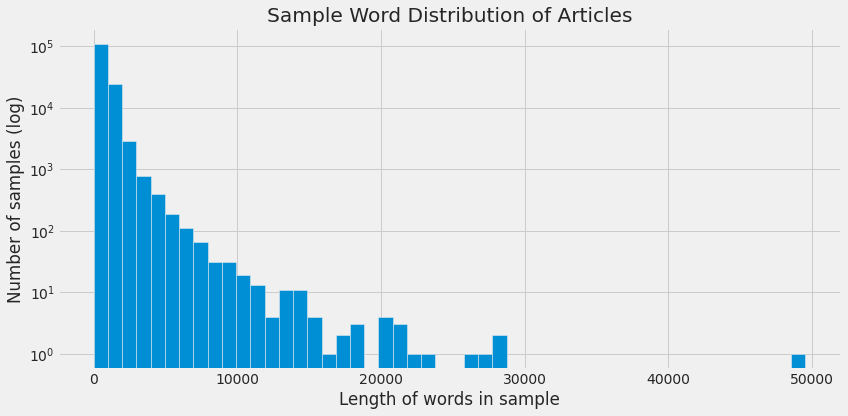

In [20]:
ax = articles["number_of_words"].plot(kind="hist", bins=50, fontsize=14, figsize=(12, 6))
ax.set_title("Sample Word Distribution of Articles")
ax.set_xlabel('Length of words in sample')
ax.set_ylabel('Number of samples (log)')
ax.set_yscale("log")
plt.tight_layout()

Our mean samples / word is ~736, with max of ~ 50000 words long article, which we can trim and remove, and lowest is 0 words, which is mostly noise words we removed.

### Articles with few words 

Now let's count the words and check the articles with fewer words.

In [21]:
articles["number_of_words"].value_counts(dropna=False, ascending=True)

4767      1
5025      1
2850      1
4897      1
4769      1
       ... 
300     181
467     181
316     183
464     183
272     190
Name: number_of_words, Length: 4223, dtype: int64

#### Articles with 0 words

In [22]:
articles[articles["number_of_words"] == 0][["cleaned_content", "cleaned_title", "number_of_words"]]

,cleaned_content,cleaned_title,number_of_words
43358,,we tried kfcs latest take on a trendy regional...,0
43406,,papa johns ceo america is on a path to becomin...,0
43465,,how this astronaut overcame failure and reject...,0
43981,,this man dropped out of college twice and now ...,0
44359,,thousands march across the country demanding t...,0
44529,,top financial adviser just working hard will n...,0
44872,,listen to audio of a gop candidate from montan...,0
45225,,mark hamill is keeping star wars fans from get...,0
45303,,exercise headphones that will make it easier t...,0
45341,,what this navy seals rule can teach you about ...,0


In [23]:
print(f"There are with {len(articles[articles['number_of_words'] == 0])} articles 0 words.")

There are with 27 articles 0 words.


Since the article is missing normally we should stop and scrape it to fill the missing article content, but in this case we can just drop the rows.

In [24]:
articles = articles[articles["number_of_words"] > 0]
articles.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 138947 entries, 0 to 142022
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   title            138931 non-null  object        
 1   publication      138947 non-null  object        
 2   date             138947 non-null  datetime64[ns]
 3   content          138947 non-null  object        
 4   cleaned_content  138947 non-null  object        
 5   cleaned_title    138931 non-null  object        
 6   number_of_words  138947 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(5)
memory usage: 8.5+ MB


In [25]:
articles.sample(10)

,title,publication,date,content,cleaned_content,cleaned_title,number_of_words
123614,How have the U.N.’s global goals fared one yea...,reuters,2016-09-21,NEW YORK (Thomson Reuters Foundation) World le...,new york thomson foundation world leaders one...,how have the uns global goals fared one year on,744
128006,Hail Caesar is the slapstick comedy about econ...,vox,2016-02-06,"Hail, Caesar! is a big, Looney Tunes confectio...",hail caesar is a big looney tunes confection o...,hail caesar is the slapstick comedy about econ...,1606
40761,LAPD officer Henry Solis sought in killing aft...,cnn,2015-03-20,Los Angeles (CNN) The search for a rookie Los ...,los angeles the search for a rookie los angel...,lapd officer henry solis sought in killing aft...,449
89427,"As the US economy slows even more, Hillary has...",new york post,2016-07-29,Just hours after Hillary Clinton promised to g...,just hours after hillary clinton promised to g...,as the us economy slows even more hillary has ...,351
132228,The web of relationships between Team Trump an...,washington post,2017-03-03,"In the most abstract sense, there is nothing n...",in the most abstract sense there is nothing no...,the web of relationships between team trump an...,1169
9790,"Buchanan on Syria: McCain, Graham, Rubio Are N...",breitbart,2017-04-10,Monday on Laura Ingraham’s nationally syndicat...,monday on laura ingrahams nationally syndicate...,buchanan on syria mccain graham rubio are not ...,284
135711,Donald Trump relishes wrecking the GOP,washington post,2016-02-21,Lyndon Johnson simply was exasperated. Barack ...,lyndon johnson simply was exasperated barack o...,donald trump relishes wrecking the gop,843
5634,‘We Still Have a Lot of People Dying’ - The Ne...,new york times,2016-08-02,BALTIMORE — I first met Brandon Scott the day ...,baltimore i first met brandon scott the day af...,we still have a lot of people dying the,951
69423,Seattle Man Arrested For Threatening Mosque On...,buzzfeed news,2016-06-16,A man who was arrested in Seattle on Tuesday a...,a man who was arrested in seattle on tuesday a...,seattle man arrested for threatening mosque on...,352
53714,The Singular Experience of the Queer Latin Nig...,atlantic,2016-06-17,I want to receive updates from partners and sp...,i want to receive updates from partners and sp...,the singular experience of the queer latin nig...,1749


#### Most Common Words - Stop Words

In [27]:
freq = pd.Series(' '.join(articles["cleaned_content"]).split())
freq_wcs = freq.value_counts()
freq_wcs[:20]

the     5910798
to      2896195
of      2611188
a       2527765
and     2491511
in      2088049
that    1401109
for      977726
is       972237
on       905002
it       714550
was      704779
he       692127
with     685155
as       646816
said     560939
his      512027
at       503562
i        492651
have     485428
dtype: int64

As we can see most common words are stop words, and removing them will have big impact in our ability to understand trends or find similar articles later on.

#### Uncommon Words

In [28]:
freq_wcs[-20:]

phaen               1
goldweber           1
deadstate           1
badlandnps          1
anique              1
aseptically         1
malufs              1
resurfacer          1
chungking           1
comunitaria         1
rymsza              1
bjursta             1
cosnervator         1
jillys              1
aesun               1
idv                 1
zeynab              1
campillos           1
zapolsky            1
mistakeembracing    1
dtype: int64

We can some of the words are very uncommon words and some have accents, andmight need dictionary for a lookup.

## 3. Save pre-processed dataset

In [29]:
# Save the cleaned data frame
articles.drop(columns=["number_of_words"], inplace=True)
articles.to_csv(ROOT_PATH.joinpath(f"data/cleaned_data/tokenize_ready_articles.csv"), index=False)